In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import json
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.2f}'.format
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
from scipy.optimize import minimize

#### code for ARMA without sector 

In [3]:
## just code for ARMA without sector 

def DailyModel(daily_data):

    estimated_daily = {}
    estimated_daily['Daily'] = Model1(daily_data)

    return Model1(daily_data)

def Model1(daily_data): #Does not currently work with the updated data inputs - WIP

    output = arma_ale(daily_data)
    return output[0]['log_total_vol_hat'], output[1], output[2]

def arma_ale(daily_data):
    ''' put it all together (make sure the date you want is within the testing set'''
    modified_data = prep_data(daily_data)
    train, test = split_dataset(modified_data, 0.7)
    y_true = train['y_true'].values
    res = minimize(my_objective, np.array([0.5, 0.5], dtype=float), args=y_true)
    phi, theta = res.x
    test['y_hat'] = estimate_y(test['y_true'].values, phi, theta)
    test['log_total_vol_hat'] = test['y_hat'] + test['log_20days_AM']
    return test, phi, theta

# be sure to prepare the dataset for later calculation easily
def prep_data(daily_data):
    '''
    Dataset preparation
    Input:
        csv_file (csv str) : your stock dataset
        stock (str) : your chosen stock capitalized symbol
    Output:
         dataset
    '''
    daily_data['log_20days_AM'] = (np.log(daily_data['total_vol_m'])).shift().rolling(20).mean()
    daily_data['y_true'] = np.log(daily_data['total_vol_m']) - daily_data['log_20days_AM']
    data = daily_data[20:]
    data['log_total_vol_m'] = np.log(data['total_vol_m'])
    #data.set_index('DATE', inplace=True)

    return data
    
def split_dataset(dataset, split_level):
    '''Split dataset into training set and testing set.'''
    n = int(len(dataset) * split_level)
    train = dataset[:n]
    test = dataset[n:]
    train.loc[:,'y_hat'] = estimate_y(train['y_true'].values, 0.7, -0.3)
    return train, test

# find y_hat given y_true
# with unknown eps, phi, theta, we need to calculate them recursively
# here assume the initial eps, which represents the error is zero
def estimate_y(y_true, phi, theta):
    '''
    Calculate y_hat based on known y_true
    Input:
        y_true (array): log(Vt) - 20-day moving average
        phi(float): universal standard is about 0.7
        theta(float): universal standard is about -0.3
    Outputs:
        y_hat (array):estimated y_true
    '''
    n = len(y_true)
    y_hat = np.zeros(n)
    eps = np.zeros(n)
    for t in range(1, n):
        y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
        eps[t] = y_true[t] - y_hat[t]
    return y_hat

def my_objective(param, y_true):
    '''
    Objective loss function for minimizing
    Find the Weighted Asymmetrical Logarithmic Error
    Input:
        param(float array): potential phi and theta
        y_true (array): log(Vt) - 20-day moving average
    Outputs:
        ALE, weighted asymmetrical logarithmic error
    '''
    phi = param[0]
    theta = param[1]
    y_hat = estimate_y(y_true, phi, theta)
    y_diff = y_hat - y_true
    #ALE = np.sum((1.5 + 0.5 * np.sign(y_diff)) * np.abs(y_diff))
    L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
    return L1_v


### code for ARMA with sector 


In [4]:
def DailyModel_sector(daily_data, sector_error): #Please get the sector_error from the ARMA running on sector vol first. See example for TECH below

    estimated_daily = {}
    estimated_daily['Daily'] = Model1_sector(daily_data, sector_error)[0]

    return Model1_sector(daily_data, sector_error)

def Model1_sector(daily_data, sector_error): 

    output = arma_ale_sector(daily_data, sector_error)
    return output[0]['log_total_vol_hat'], output[1], output[2], output[3]

def arma_ale_sector(daily_data, sector_error):
    ''' put it all together (make sure the date you want is within the testing set'''
    modified_data = prep_data(daily_data)
    train, test = split_dataset_sector(modified_data, 0.7,sector_error)
    y_true = train['y_true'].values
    res = minimize(my_objective_sector, np.array([0.5, 0.5, 0.5], dtype=float), args=(y_true, sector_error))
    phi, theta, s = res.x
    test['y_hat'] = estimate_y_sector(test['y_true'].values, phi, theta, s, sector_error)
    test['log_total_vol_hat'] = test['y_hat'] + test['log_20days_AM']
    return test, phi, theta, s

# be sure to prepare the dataset for later calculation easily
def prep_data(daily_data):
    '''
    Dataset preparation
    Input:
        csv_file (csv str) : your stock dataset
        stock (str) : your chosen stock capitalized symbol
    Output:
         dataset
    '''
    daily_data['log_20days_AM'] = (np.log(daily_data['total_vol_m'])).shift().rolling(20).mean()
    daily_data['y_true'] = np.log(daily_data['total_vol_m']) - daily_data['log_20days_AM']
    data = daily_data[20:]
    data['log_total_vol_m'] = np.log(data['total_vol_m'])
    #data.set_index('DATE', inplace=True)

    return data
    
def split_dataset_sector(dataset, split_level, sector_error):
    '''Split dataset into training set and testing set.'''
    n = int(len(dataset) * split_level)
    train = dataset[:n]
    test = dataset[n:]
    train.loc[:,'y_hat'] = estimate_y_sector(train['y_true'].values, 0.7, -0.3, 0.1, sector_error)
    return train, test

# find y_hat given y_true
# with unknown eps, phi, theta, we need to calculate them recursively
# here assume the initial eps, which represents the error is zero
def estimate_y_sector(y_true, phi, theta, s, sector_err):
    '''
    Calculate y_hat based on known y_true
    Input:
        y_true (array): log(Vt) - 20-day moving average
        phi(float): universal standard is about 0.7
        theta(float): universal standard is about -0.3
    Outputs:
        y_hat (array):estimated y_true
    '''
    n = len(y_true)
    y_hat = np.zeros(n)
    eps = np.zeros(n)
    for t in range(1, n):
        y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1]
        if n-t <= 71: #sector error's date starts from 2019-09-24, which is the testing part
            y_hat[t] = phi * y_true[t - 1] + theta * eps[t - 1] + s*sector_err[65-(n-t)]
        eps[t] = y_true[t] - y_hat[t]
    return y_hat

def my_objective_sector(param, y_true, sector_err):
    '''
    Objective loss function for minimizing
    Find the Weighted Asymmetrical Logarithmic Error
    Input:
        param(float array): potential phi and theta
        y_true (array): log(Vt) - 20-day moving average
    Outputs:
        ALE, weighted asymmetrical logarithmic error
    '''
    phi = param[0]
    theta = param[1]
    s = param[2]
    y_hat = estimate_y_sector(y_true, phi, theta, s, sector_err)
    y_diff = y_hat - y_true
    #ALE = np.sum((1.5 + 0.5 * np.sign(y_diff)) * np.abs(y_diff))
    L1_v = np.sum(abs(y_diff/y_true)) # scaling matrics : sum of |v-v^|/v
    return L1_v


In [5]:
sp = pd.read_csv("/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/SP500/SP500_daily/SP500_daily.csv")
sp['DATE'] = pd.to_datetime(sp['DATE'].astype(str), format='%Y%m%d')
sp['DATE']= pd.to_datetime(sp.DATE)
payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]
list = first_table.Symbol.unique()
use = first_table[['Symbol','GICS Sector']]
use.set_index
use = use.rename(columns={"GICS Sector": "Sector"})
use = use.set_index('Symbol')
sp['Sector'] = sp.SYM_ROOT.map(use.to_dict()['Sector'])
sp['log_vol'] = np.log(sp.total_vol_m)

In [6]:
sp = sp[sp.DATE <= '2020-01-03']

In [7]:
def get_Sector(Sect):
    sector = sp.loc[sp.Sector == Sect].groupby(['DATE','symbol']).sum().groupby('DATE').sum()
    sector.log_vol = np.log(sector.total_vol_m)
    #sector['ave'] = sector.log_vol.rolling(20).mean()
    #sector['sect_diff'] = sector.log_vol - sector.ave
    return sector

In [8]:
TECH = get_Sector('Information Technology')
FIN = get_Sector('Financials')
CD = get_Sector('Consumer Discretionary')
CS = get_Sector('Consumer Services')
IN = get_Sector('Industrials')
HC = get_Sector('Health Care')
NRG = get_Sector('Energy')
MAT = get_Sector('Materials')
UTIL = get_Sector('Utilities')
RE = get_Sector('Real Estate')

#### To get the sector residual first - Sample: TECH

In [9]:
TECH

,CSize,OSize,total_vol_m,total_vol_b,total_vol_a,log_vol
DATE,,,,,,
2019-01-02,32416203.00,3850781.00,397367674.00,2571073.00,33154290.00,19.80
2019-01-03,38925116.00,5369632.00,595120176.00,5408443.00,21271747.00,20.20
2019-01-04,51168636.00,3879372.00,534402051.00,3905021.00,16927214.00,20.10
2019-01-07,35883334.00,3763660.00,489958694.00,2877337.00,26037703.00,20.01
2019-01-08,32838919.00,4363839.00,471852435.00,3605866.00,23432553.00,19.97
...,...,...,...,...,...,...
2019-12-27,25229403.00,3019612.00,220010566.00,2188658.00,16649537.00,19.21
2019-12-30,19931808.00,2634059.00,239540453.00,1248575.00,10896338.00,19.29
2019-12-31,34827557.00,2423657.00,220419572.00,2287372.00,17975344.00,19.21


In [10]:
np.log(TECH[TECH.index >= '2019-09-24']['total_vol_m'])

DATE
2019-09-24   19.81
2019-09-25   19.59
2019-09-26   19.48
2019-09-27   19.74
2019-09-30   19.55
              ... 
2019-12-27   19.21
2019-12-30   19.29
2019-12-31   19.21
2020-01-02   19.68
2020-01-03   19.56
Name: total_vol_m, Length: 71, dtype: float64

In [11]:
DailyModel(TECH)[0]

DATE
2019-09-24   19.58
2019-09-25   19.60
2019-09-26   19.60
2019-09-27   19.60
2019-09-30   19.63
              ... 
2019-12-27   19.47
2019-12-30   19.47
2019-12-31   19.50
2020-01-02   19.48
2020-01-03   19.51
Name: log_total_vol_hat, Length: 71, dtype: float64

In [12]:
sector_error = np.log(TECH[TECH.index >= '2019-09-24']['total_vol_m']) - DailyModel(TECH)[0]
sector_error

DATE
2019-09-24    0.23
2019-09-25   -0.01
2019-09-26   -0.12
2019-09-27    0.15
2019-09-30   -0.08
              ... 
2019-12-27   -0.26
2019-12-30   -0.18
2019-12-31   -0.29
2020-01-02    0.20
2020-01-03    0.05
Length: 71, dtype: float64

### Getting the stock tickers in the sector and organize it into list

In [13]:
tech_df = pd.read_csv('/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/ARMA/sector_arma/infotech-symbol.csv')
fin_df = pd.read_csv('/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/ARMA/sector_arma/financials-symbol.csv')
ind_df = pd.read_csv('/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/ARMA/sector_arma/industrials-symbol.csv')
re_df = pd.read_csv('/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/ARMA/sector_arma/real-estate-symbol.csv')
utli_df = pd.read_csv('/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/ARMA/sector_arma/utilities-symbol.csv')
heath_df = pd.read_csv('/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/ARMA/sector_arma/health-care-symbol.csv')

In [14]:
tech_lst = tech_df['Symbol'].unique().tolist()[:-1] # the last one isnot related, is just the source tag where we download the csv
fin_lst = fin_df['Symbol'].unique().tolist()[:-1]
ind_lst = ind_df['Symbol'].unique().tolist()[:-1]
re_lst = re_df['Symbol'].unique().tolist()[:-1]
utli_lst = utli_df['Symbol'].unique().tolist()[:-1]
health_lst = heath_df['Symbol'].unique().tolist()[:-1]

In [15]:
def get_one_stock(ticker):
    '''getting one ticker from the sector stock list '''
    stock = sp.loc[sp.symbol == ticker]
    stock = stock.set_index(stock.DATE)
    stock = stock.drop('DATE',axis=1)
    return stock

In [16]:
def dump(ticker, storage_dict, with_coeff,coeff, error, with_err):
    '''dumping everything into the dictionary'''
    storage_dict[ticker] = {'without': {'coefficient':coeff, 'residual':error}, \
                             'with': {'coefficient':with_coeff,'residual': with_err}}
    return 

In [208]:
def update_storage(sector_lst,sector_err):
    for ticker in sector_lst:
        select_stock = get_one_stock(ticker)
        w_sector = DailyModel_sector(select_stock, sector_err)
        without_sector = DailyModel(select_stock)
        true_vol = select_stock[select_stock.index >= '2019-09-24']['log_vol'].values #because all stocks splited in the same way, which is the same date
        residual = np.sum(np.abs(true_vol - without_sector[0].values) / true_vol)
        with_residual = np.sum(np.abs(true_vol - w_sector[0].values) / true_vol)
        dump(ticker,stock_storage, tuple(w_sector[1:]), \
            tuple(without_sector[1:]),  residual, with_residual)

In [210]:
stock_storage = {}

In [209]:
def go(sector_df, sector_lst):
    sector_err = np.log(sector_df[sector_df.index >= '2019-09-24']['total_vol_m']) \
               - DailyModel(sector_df)[0]
    update_storage(sector_lst, sector_err)

In [211]:
go(UTIL, utli_lst)

In [212]:
stock_storage.keys()

dict_keys(['AEE', 'AEP', 'AES', 'ATO', 'AWK', 'CEG', 'CMS', 'CNP', 'D', 'DTE', 'DUK', 'ED', 'EIX', 'ES', 'ETR', 'EVRG', 'EXC', 'FE', 'LNT', 'NEE', 'NI', 'NRG', 'PEG', 'PNW', 'PPL', 'SO', 'SRE', 'WEC', 'XEL'])

In [215]:
utli_lst.index('XEL')

28

In [216]:
with open("utli_stocks_29.json", "w") as outfile:
    json.dump(stock_storage, outfile)

### Residual visualization

In [217]:
with open('/Users/zss/OneDrive - The University of Chicago/DRW_Trading/self_edit/ARMA/sector_arma/tech_stocks_75.json') as json_file:
    tech = json.load(json_file)

In [218]:
tech.keys()

dict_keys(['AAPL', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANET', 'ANSS', 'APH', 'AVGO', 'BR', 'CDAY', 'CDNS', 'CDW', 'CRM', 'CSCO', 'CTSH', 'CTXS', 'DXC', 'ENPH', 'EPAM', 'FFIV', 'FIS', 'FISV', 'FLT', 'FTNT', 'GLW', 'GPN', 'HPE', 'HPQ', 'IBM', 'INTC', 'INTU', 'IPGP', 'IT', 'JKHY', 'JNPR', 'KEYS', 'KLAC', 'LRCX', 'MA', 'MCHP', 'MPWR', 'MSFT', 'MSI', 'MU', 'NOW', 'NTAP', 'NVDA', 'NXPI', 'ORCL', 'PAYC', 'PAYX', 'PTC', 'PYPL', 'QCOM', 'QRVO', 'SEDG', 'SNPS', 'STX', 'SWKS', 'TDY', 'TEL', 'TER', 'TRMB', 'TXN', 'TYL', 'V', 'VRSN', 'WDC', 'ZBRA'])

In [220]:
tech['AAPL']['with']['residual']

0.9646009316712677

In [221]:
tech['AAPL']['without']['residual']

0.9702699648825772

In [223]:
with_residual = []
residual = []
for key in tech.keys():
    with_residual.append(tech[key]['with']['residual'])
    residual.append(tech[key]['without']['residual'])

In [225]:
import seaborn as sns
import matplotlib.pyplot as plt

In [227]:
check = {'name':tech.keys(), 'with_sec': with_residual, 'raw':residual}

In [228]:
df = pd.DataFrame(check)
df

,name,with_sec,raw
0,AAPL,0.96,0.97
1,ACN,1.29,1.28
2,ADBE,1.58,1.57
3,ADI,1.75,1.73
4,ADP,1.53,1.51
...,...,...,...
69,TYL,1.76,1.75
70,V,1.10,1.24
71,VRSN,1.63,1.62
72,WDC,1.43,1.44


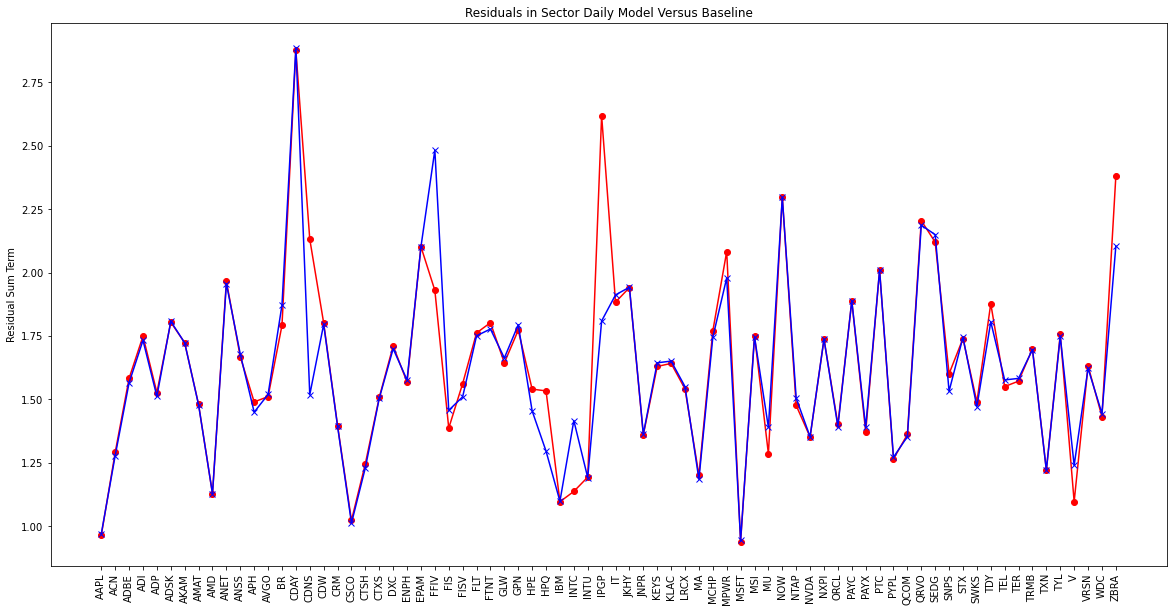

In [299]:
plt.figure(figsize=(20,10))

plt.plot(df['name'], df['with_sec'], 'o', color='red')
plt.plot(df['name'], df['with_sec'], color='red')
plt.plot(df['name'], df['raw'], 'x', color='blue')
plt.plot(df['name'], df['raw'], color='blue')
plt.ylabel('Residual Sum Term')
plt.title('Residuals in Sector Daily Model Versus Baseline')
plt.xticks(rotation=90);


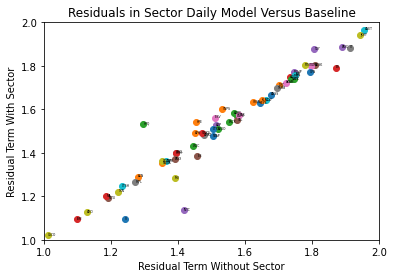

In [290]:
for ticker in tech.keys():
    plt.xlabel('Residual Term Without Sector')
    plt.ylabel('Residual Term With Sector')
    plt.title('Residuals in Sector Daily Model Versus Baseline')
    try:
        with_s = tech[ticker]['with']['residual']
        without_s = tech[ticker]['without']['residual']
        plt.scatter(without_s,with_s)
        plt.annotate(ticker,(without_s,with_s),fontsize=3)
    except:
        pass
plt.xlim(1,2)
plt.ylim(1,2)
#plt.savefig('Comparison_Fin_Daily_regression.png', dpi=300)
plt.show()